The code aims to analyze spatial properties of public transport routes globally.
The input is the spatial road network and route structure of the buses.
The code analyzes the detour distribution of bus routes and other spatial aspects such as route interconnectivity.

# Initialization

In [3]:
import os
import json
import shapely
from shapely.geometry import Polygon
import plotly.express as px
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import random
from shapely.geometry import shape
from shapely.geometry import LineString
from osgeo import ogr, osr
import geopandas as gpd
import pandas as pd
import time
import networkx as nx
import osmnx as ox
from pyproj import Geod
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
geod=Geod(ellps="WGS84")                    
import matplotlib
import geopy.distance

In [4]:
""" 
List of cities we have the data for.
"""


City_tag_list=["Cochabamba", "Accra", "Addis Ababa", "Brisbane", "Columbus",
                 "Coventry", "Dortmund", "Dresden", "Duitama", "Dusseldorf", "Hanover", "Indianapolis", "Istanbul",
                 "Leipzig", "Lyon", "Minneapolis", "Montreal", "Naples", "Nottingham", "Nouakchott", "Pittsburgh",
                 "Sheffield", "Sydney", "Tetouan","Toronto", "Toulouse", "Washington", "Wolverhampton","Abidjan","Bandung", "Dar es Salaam","Kigali","Kochi","Manila","Nairobi","Tehran"]


# Functions

In [1]:
"""
Functions used in the code
"""

""" 
Linestring is the standard format for dealing with coordinate sequence in python, the following make a linestring,
from a node sequence.
"""

def nodes_to_linestring(path):
    coords_list = [(G.nodes[i]['x'], G.nodes[i]['y']) for i in path ]
    line = LineString(coords_list)
    return(line)

"""
Following finds the shortest street network path between two sets of coordinates on the street.
"""

def shortestpath(origin,destination):
    shortest_p=ox.distance.shortest_path(G=G,orig=origin, dest=destination)
    route = nodes_to_linestring(shortest_p)
    length = geod.geometry_length(route)
    return(route,length)

"""
There is a possibility that a particular origin destination pair are not exactly on the street network but shifted,
In that case we find the coordinate on the street network closest to our origin-destination pair and find the
shortest path between these points.
"""

def shortestpath_coordinates(origin,destination,ac_route,ac_len,counter_no_path,error_holder):
    node_origin=ox.distance.nearest_nodes(G=G,X=origin[0],Y=origin[1])
    node_destination=ox.distance.nearest_nodes(G=G,X=destination[0] ,Y=destination[1])
    shortest_p=ox.distance.shortest_path(G=G,orig=node_origin, dest=node_destination)
    if shortest_p==None:
        route=ac_route
        length=ac_len
        counter_no_path=counter_no_path+1
        error_holder.append(i)
        print('shortest_p=none',i)
    elif len(shortest_p)==1:
        route=ac_route
        length=ac_len
        counter_no_path=counter_no_path+1
        print('shortest_p=1',i)
        error_holder.append(i)
    else:
        route = nodes_to_linestring(shortest_p)
        length = geod.geometry_length(route)
    
    return(route,length)

"""
Reads json at path. json can be created at http://geojson.io/.
:param path_to_json: file path to json.
:type path_to_json: str
:return: Polygon given by json
:rtype: Shapely polygon
"""


def get_polygon_from_json(path_to_json):
    with open(path_to_json) as j_file:
        data = json.load(j_file)
    coordinates = data['features'][0]['geometry']['coordinates'][0]
    coordinates = [(item[0], item[1]) for item in coordinates]
    polygon = Polygon(coordinates)
    return polygon

"""
Plot a sequence of linestring on world map.
"""

def linestring_plotter(line_string):
    lats=list(line_string.xy[0])
    lons=list(line_string.xy[1])

        
    fig = px.line_mapbox(lat=lons, lon=lats,
                     mapbox_style="stamen-terrain", zoom=10)
    fig.show()
    
"""
The following functions respectively find the distance of linestring and list in meters and standard units.
"""

def linestring_dist(line_string):
    temp_len_string=ogr.CreateGeometryFromWkt(line_string.wkt)
    return temp_len_string.Length()

def linestring_dist_meter(line_string):
    temp_len_string=geod.geometry_length(line_string)
    return temp_len_string
    
    
def list_dist(list_string):
    line_string=LineString(list_string)
    temp_len_string=ogr.CreateGeometryFromWkt(line_string.wkt)
    return temp_len_string.Length()

def list_dist_meter(list_string):
    line_string=LineString(list_string)
    temp_len_string=geod.geometry_length(line_string)
    return temp_len_string
    
"""
The function splits a route into 'parts_routes' parts of equal length and returns the indivual segments of the route 
"""
            
def split_route_distance(route,parts_route):
    parts_route_assemble=[]
    # making list for the number of parts we want the route to be divided into
    for j in range(parts_route):
        parts_route_assemble.append([])
    # randomly starting from start or end
    order_distance=random.choice([0,1])
    #We take the list of points and keep on adding the points till we reach length just greater than L/parts route
    if order_distance==0:
        l=0
        for j in range(parts_route-1):
            # print(route[0,1])
            l=l+1 
            parts_route_assemble[j].append(route[l-1])
            parts_route_assemble[j].append(route[l])
            # print(list_dist(route)/parts_route)
            while list_dist_meter(parts_route_assemble[j])<=list_dist_meter(route)/parts_route and l+1 != len(route):
                    l=l+1
                    parts_route_assemble[j].append(route[l])
        parts_route_assemble[-1]=route[l:]
        
        
    
    elif order_distance==1:
        l=len(route)-1
        for j in (range(parts_route-1,0,-1)):
            l=l-1 
            parts_route_assemble[j].insert(0,route[l+1])
            parts_route_assemble[j].insert(0,route[l])
            while list_dist_meter(parts_route_assemble[j])<=list_dist_meter(route)/parts_route and l-1!=0:
                l=l-1
                parts_route_assemble[j].insert(0,route[l])
        parts_route_assemble[0]=route[0:l+1]    
        
    if l+1==len(route) or l-1==0 :
        return "error"
    else:
        return(parts_route_assemble)

"""
Here one can create a total of 'total_scan_points' segments of length specified by 'parts_routes'
"""
    
def split_route_distance_scan(route,parts_route,total_scan_points):

    parts_route_assemble=[]
    # number of scan of length L/parts route we want to do
    for temp in np.arange(total_scan_points):
        parts_route_assemble.append([])
    
    l=len(route)-1
    l=l-1 
    
    # adding last two points in the tupple so that we can calculate the first distance while starting the while loop
    parts_route_assemble[-1].insert(0,route[l+1])
    parts_route_assemble[-1].insert(0,route[l])
    
    # idea is to make the last possible segment of length L/parts route, then from the coordinate this segment starts we divide the coordinates from 0 to this coordinate in 
    # total parts-1 segments, note that we canot take any segment beyond that coordinate as then the length will be < L/parts route 
    
    while list_dist_meter(parts_route_assemble[-1])<=list_dist_meter(route)/parts_route and l-1!=0:
        l=l-1
        parts_route_assemble[-1].insert(0,route[l])

    
    for temp in np.arange(total_scan_points-1):
        l=int(np.linspace(0,list(route).index(parts_route_assemble[-1][0]),total_scan_points)[temp])
        parts_route_assemble[temp].append(route[l])
        l=int(np.linspace(0,list(route).index(parts_route_assemble[-1][0]),total_scan_points)[temp])+1
        parts_route_assemble[temp].append(route[l])

        while list_dist_meter(parts_route_assemble[temp])<=list_dist_meter(route)/parts_route and l+1 != len(route):
                        l=l+1
                        parts_route_assemble[temp].append(route[l])

    
    return(parts_route_assemble)

"""
Waiting route properties by the number of people a route serves.
"""
def pop_weighted_dict_generator_ratiod(dict_sample,pop_dist):
    dict_weightd={}
    pop_ratiod={}
    for i in np.arange(len(pop_dist)):
        pop_ratiod[i]=(pop_dist[i]/min(pop_dist[i])).astype(int)
    for i in np.arange(len(dict_sample)):
        print(i)
        temp=[]
        for j in np.arange(len(dict_sample[i])):
            for k in np.arange(int(pop_ratiod[i][j])):
                temp.append(dict_sample[i][j]) 

        dict_weightd[i]=temp
        
    return dict_weightd
        


In [2]:
"""
Load the data in form of polygon for the streetboundary downloaded from gojson.io,  named as map_'cityname' in our case.
Load the Geojson data for the bus routes which containes the route paths, downloaded from openstreet maps 
using overpass turbo. The data is saved in our directory by the name export_'cityname'.
"""

export_holder=[]
map_holder=[]

a="/Users/kumi759c/Desktop/Paratransit_code/"
for entry in os.listdir(a):
    if entry[0]=='e':
        export_holder.append(str(entry))
    elif entry[0]=='m':
        map_holder.append(str(entry))
    
export_holder.remove('export_Delhi.geojson')
export_holder.remove('export_Dortmund_smaller.geojson')
export_holder.remove('export_Leeds.geojson')
export_holder.remove('export_Sevilla.geojson')
export_holder.remove('export_z_Mashhad.geojson')

map_holder.remove('map_Cocha_ggl.geojson')
map_holder.remove('map_Delhi.geojson')
map_holder.remove('map_Leeds.geojson')
map_holder.remove('map_Sevilla.geojson')
map_holder.remove('map_z_Mashhad.geojson')

print(len(map_holder))
print(len(export_holder))

NameError: name 'os' is not defined

# Runner

In [ ]:
"""
The main code body for our simulation.
Here we itterate over each city and divide routes into segments of varying length, for each segment of a route,
we compare the length of the actual route with that of the shortest possible route the bus could have taken between
the end points of the segment.
"""

dict_actual_dist={}
dict_shortest_dist={}
dict_actual_route={}
dict_shortest_route={}
dict_total_dist={}
dict_arrray={}
dict_cell_intersec={}
dict_num_intersec={}



for city in np.arange(len(map_holder)):
    
    'Downloading the street network from the boundary polygon of a city.'
    
    print(city)
    path_to_json="/Users/kumi759c/Desktop/Paratransit_code/"+map_holder[city]
    print(path_to_json)
    polygon_city=get_polygon_from_json(path_to_json)
    G=ox.graph.graph_from_polygon(polygon=polygon_city)
    nodes, edges = ox.graph_to_gdfs(G)
    
    'Filtering the bus route data file to remove empty columns'
    
    path="/Users/kumi759c/Desktop/Paratransit_code/"+export_holder[city]
    print(path)
    gdf = geopandas.read_file(path)
    boroughs_4326 = gdf.to_crs("EPSG:4326")                                                                                  
    brs=boroughs_4326[boroughs_4326.id.str.contains('relation')].dropna(how='all', axis=1)                       
    brs=brs[set(brs.columns)-{'.'}]
    
    'Kontur population distribution dataset masked to contain only the region within city boundary.'
    
    pop_dist_City=gpd.read_file("kontur_pop_EPSG.gpkg",mask=polygon_city)
    
    
    
    parts_route=3                            #'number of parts the route should be divided into'
    counter_no_path=0                        #for some routest shortest route can't be found as nearest nodes is not exact, for them actual path=shortest path

    actual_dist_assemble=[]
    actual_route_assemble=[]
    shortest_dist_assemble=[]
    shortest_route_assemble=[]
    
    cell_intersec_holder=[]
    num_cell_intersec=[]

    for j in range(parts_route):
        actual_dist_assemble.append([])
        shortest_dist_assemble.append([])
        shortest_route_assemble.append([])

    arrray=list(range(len(brs))) 
    error_holder=[]
    temp_arrray=[]
    total_dist_array=[]
    
    for i in arrray:
        
        #Below we filter the bus GPS dataset to exclude the bus routes that are incomplete
        
        temp_route=brs.iloc[i].geometry                     
        if str(type(brs.iloc[i].geometry))=="<class 'shapely.geometry.multilinestring.MultiLineString'>":
            temp_coords=list(temp_route[0].coords)
        
        elif str(type(brs.iloc[i].geometry))=="<class 'shapely.geometry.polygon.Polygon'>":
            continue
        
        else: 
            temp_coords=list(temp_route.coords)
        'distance actual routes segment'
        if len(temp_coords)<10:
            continue
        else:
            # Here we split the route into number of parts and check if the individual segments have appropriate structure
            split_route_assemble =split_route_distance(temp_coords,parts_route) 
            if split_route_assemble=="error":
                print("ohno")
                continue
            else:

                # print(split_route_assemble)
                len_assigner=0
                for len_check in split_route_assemble:
                    # print(len(len_check))
                    if len(len_check)<2:
                        len_assigner=1
                        # print(len_assigner)

                if len_assigner==1:
                    continue

                elif len_assigner==0:
                    
                    #Below this points we considere filtered route which have appropriate route length and data structure
                    
                    total_dist_array.append(list_dist_meter(temp_coords)) #total length of the route
                    temp_arrray.append(i)
                    
                    # Here we take note of the different split parts of the route, the gps coordinate and the length.
                    
                    actual_route_assemble.append(split_route_assemble)
                    for m in range(parts_route): 
                        actual_dist_assemble[m].append(list_dist_meter(split_route_assemble[m]))

                    # The shortest route path and length are found in the following.

                    for n in range(parts_route):
                        short_route, short_dist=shortestpath_coordinates(origin=split_route_assemble[n][0] ,destination=split_route_assemble[n][-1],ac_route=split_route_assemble[n],ac_len=list_dist_meter(split_route_assemble[n]),counter_no_path=counter_no_path,error_holder=error_holder)
                        shortest_route_assemble[n].append(short_route)
                        shortest_dist_assemble[n].append(short_dist)
                        
                    # population data analysis route and segment wise, here we count the number of hexagons a route
                    # intersects. The hexagons here are the Kontur population dataset information stored format. 
                                        '
                
                    temp_cell_counter=0
                    temp_cell_intersec=0
                    for hec_iiter in np.arange(len(pop_dist_City)):

                        'for the whole route'
                        temp_1=pop_dist_City.iloc[hec_iiter].geometry
                        temp_2=brs.iloc[i].geometry


                        if temp_1.intersects(temp_2)== True:
                            temp_cell_counter=temp_cell_counter+pop_dist_City.iloc[hec_iiter].population
                            temp_cell_intersec=temp_cell_intersec+1

                    cell_intersec_holder.append(temp_cell_counter) 
                    num_cell_intersec.append(temp_cell_intersec)
    
    
    
    
    dict_total_dist[city]=total_dist_array
    dict_actual_dist[city]=actual_dist_assemble
    dict_shortest_dist[city]=shortest_dist_assemble
    dict_actual_route[city]=actual_route_assemble
    dict_shortest_route[city]=shortest_route_assemble
    dict_arrray[city]=temp_arrray
    dict_cell_intersec[city]=cell_intersec_holder
    dict_num_intersec[city]=num_cell_intersec
    
    

In [ ]:
"""
In the above we divided the route into fixed number of segments as for our route structure analysis 
for the parameters detour heterogeniety, total detour and route connectivity a continuos scan is not required and 
considering only specific segments ave time.
For the 50 points segment scan we denote in our paper, one can run the following code.
"""

## Continuos segment runner

In [ ]:


total_scan_points=50
parts_route=3   

for city in np.arange(len(map_holder)):
    
    dict_actual_dist={}
    dict_shortest_dist={}
    dict_actual_route={}
    dict_shortest_route={}
    dict_total_dist={}
    dict_arrray={}
    
    print(city)
    
    path_to_json="/Users/kumi759c/Desktop/Paratransit_code/"+map_holder[city]
    print(path_to_json)
    polygon_city=get_polygon_from_json(path_to_json)
    G=ox.graph.graph_from_polygon(polygon=polygon_city)
    nodes, edges = ox.graph_to_gdfs(G)
    
    path="/Users/kumi759c/Desktop/Paratransit_code/"+export_holder[city]
    print(path)
    gdf = geopandas.read_file(path)
    boroughs_4326 = gdf.to_crs("EPSG:4326")                                                                                  
    brs=boroughs_4326[boroughs_4326.id.str.contains('relation')].dropna(how='all', axis=1)                       
    brs=brs[set(brs.columns)-{'.'}]
    
    
    
    
    #'number of parts the route should be divided into'
    
    counter_no_path=0                        #for some routest shortest route can't be found as nearest nodes is not exact, for them actual path=shortest path

    actual_dist_assemble=[]
    actual_route_assemble=[]
    shortest_dist_assemble=[]
    shortest_route_assemble=[]

    for j in range(total_scan_points):
        actual_dist_assemble.append([])
        shortest_dist_assemble.append([])
        shortest_route_assemble.append([])

    arrray=list(range(len(brs))) 
    error_holder=[]
    temp_arrray=[]
    total_dist_array=[]
    
    for i in arrray:
        print(i)
        temp_route=brs.iloc[i].geometry 
        if str(type(brs.iloc[i].geometry))=="<class 'shapely.geometry.multilinestring.MultiLineString'>":
            temp_coords=list(temp_route[0].coords)
        
        elif str(type(brs.iloc[i].geometry))=="<class 'shapely.geometry.polygon.Polygon'>":
            continue
        
        else: 
            temp_coords=list(temp_route.coords)
        'distance actual routes segment'
        if len(temp_coords)<10:
            continue
        else:
            split_route_assemble =split_route_distance_scan(temp_coords,parts_route,total_scan_points)
            if split_route_assemble=="error":
                print("ohno")
                continue
            else:

                # print(split_route_assemble)
                len_assigner=0
                for len_check in split_route_assemble:
                    # print(len(len_check))
                    if len(len_check)<2:
                        len_assigner=1
                        # print(len_assigner)

                if len_assigner==1:
                    continue

                elif len_assigner==0:
                    
                    total_dist_array.append(list_dist_meter(temp_coords))
                    temp_arrray.append(i)
                    actual_route_assemble.append(split_route_assemble)
                    for m in range(total_scan_points): 
                        # print((split_route_assemble[m]))
                        actual_dist_assemble[m].append(list_dist_meter(split_route_assemble[m]))

                    'distance shotest segment'

                    for n in range(total_scan_points):
                        short_route, short_dist=shortestpath_coordinates(origin=split_route_assemble[n][0] ,destination=split_route_assemble[n][-1],ac_route=split_route_assemble[n],ac_len=list_dist_meter(split_route_assemble[n]),counter_no_path=counter_no_path,error_holder=error_holder)
                        shortest_route_assemble[n].append(short_route)
                        shortest_dist_assemble[n].append(short_dist)
    
    
    
    
    dict_total_dist[city]=total_dist_array
    dict_actual_dist[city]=actual_dist_assemble
    dict_shortest_dist[city]=shortest_dist_assemble
    dict_actual_route[city]=actual_route_assemble
    dict_shortest_route[city]=shortest_route_assemble
    dict_arrray[city]=temp_arrray
    
    temp_string='/Users/kumi759c/Desktop/Paratransit_code/SCAN_data/'+str(City_tag_list[city])
    
    os.mkdir(temp_string)
    
    np.save(temp_string+"/dict_act_dist.npy",dict_actual_dist[city])
    np.save(temp_string+"/dict_short_dist.npy",dict_shortest_dist[city])
    np.save(temp_string+"/dict_act_route.npy",dict_actual_route[city])
    np.save(temp_string+"/dict_short_route.npy",dict_shortest_route[city])
    np.save(temp_string+"/dict_arrray.npy",dict_arrray[city])

Abidjan


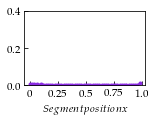

Accra


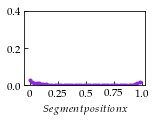

Addis Ababa


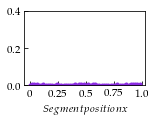

Bandung


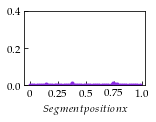

Brisbane


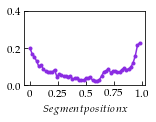

Cape Town


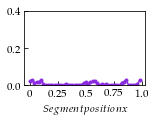

Cochabamba


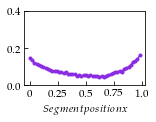

Columbus


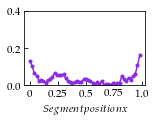

Coventry


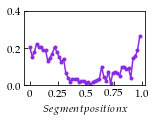

Dar es Salaam


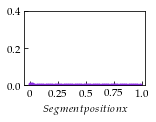

Dortmund


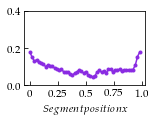

Dresden


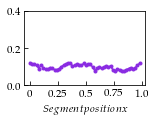

Duitama


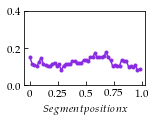

Dusseldorf


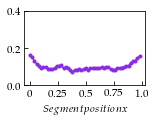

Hannover


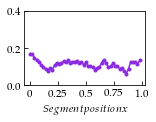

Indianapolis


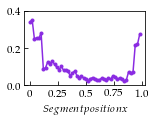

Istanbul


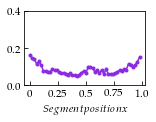

Kigali


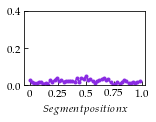

Kochi


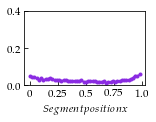

Leipzig


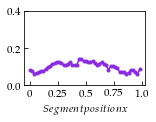

Lyon


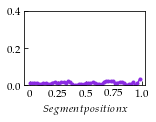

Manila


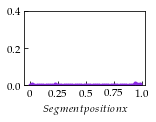

Montreal


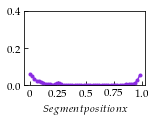

Nairobi


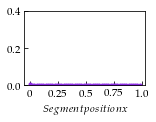

Naples


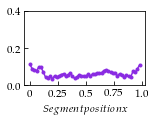

Nottingham


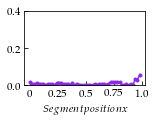

Nouakchott


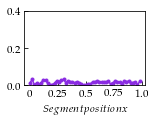

Pittsburgh


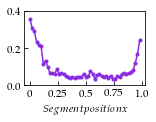

Sheffield


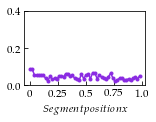

Sydney


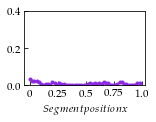

Tehran


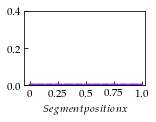

Tetouan


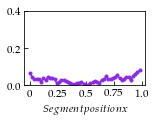

Toronto


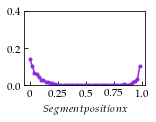

Toulouse


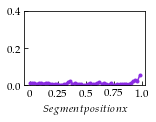

Wolverhampton


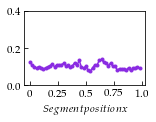

In [248]:
"""
Here we are loading data and showing the corresponding plots as an illustration
"""

a="/Users/kumi759c/Desktop/Paratransit_code/SCAN_data"

for entry in os.listdir(a):
    
    print(entry)
    
    dict_actual_dist=np.load("/Users/kumi759c/Desktop/Paratransit_code/SCAN_data/"+entry+"/dict_act_dist.npy", allow_pickle=True)
    dict_shortest_dist=np.load("/Users/kumi759c/Desktop/Paratransit_code/SCAN_data/"+entry+"/dict_short_dist.npy", allow_pickle=True)
    dict_actual_route=np.load("/Users/kumi759c/Desktop/Paratransit_code/SCAN_data/"+entry+"/dict_act_route.npy", allow_pickle=True)
    dict_shortest_route=np.load("/Users/kumi759c/Desktop/Paratransit_code/SCAN_data/"+entry+"/dict_short_route.npy", allow_pickle=True)
    dict_arrray=np.load("/Users/kumi759c/Desktop/Paratransit_code/SCAN_data/"+entry+"/dict_arrray.npy", allow_pickle=True)
    
    'initialising the quantities' 
    key=0


    for i in np.arange(len(dict_actual_dist)):
        for j in np.arange(len(dict_actual_dist[i])):
            
                if dict_actual_dist[i][j]<dict_shortest_dist[i][j]:
                    dict_shortest_dist[i][j]=dict_actual_dist[i][j]





    temp_detou_avg=[]
    detour_collector=(np.array(dict_actual_dist)-np.array(dict_shortest_dist))/np.array(dict_actual_dist)

    for i in detour_collector:
        temp_detou_avg.append(np.average(i))

    # sum_act_dist=np.sum(dict_actual_dist[key],axis=1)
    # sum_shortest_dist=np.sum(dict_shortest_dist[key],axis=1)
    
    
    



    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
        "font.size"   : 11,
        "font.weight": "bold",
    })

    # plt.rcParams["font.weight"] = "bold"
    # temp_label=['Cochabamba', 'Indianapolis', 'Montreal']
    # i=5
    plt.figure
    width, height = 55/25.4, 35/25.4
    plt.figure(figsize=(width, height))
    # temp=0
    # for i in [i]:
            # plt.plot([0,1,2],[1/(sum(dict_actual_dist[i][0])/sum(dict_actual_dist[i][0])),1/(sum(dict_actual_dist[i][1])/sum(dict_actual_dist[i][1])),1/(sum(dict_actual_dist[i][2])/sum(dict_actual_dist[i][2]))])
    plt.plot(np.arange(len(np.median(detour_collector,axis=1))),np.median(detour_collector,axis=1),'.-',c='blueviolet')
        # plt.plot(np.arange(len(dict_actual_dist[key])),(sum_act_dist-sum_shortest_dist)/sum_act_dist)
    # temp=temp+1
    # plt.xticks([0,1,2],[1,2,3])
    # plt.ylabel(" $<d>$")
    plt.xlabel(" $Segment position x$ ")
    plt.ylim(0,0.4)
    # plt.yticks((0,0.1,0.15),(0,0.1,0.15))
    plt.tick_params(axis='both', direction='in', length=4)
    # plt.xticks(np.append(np.arange(len(temp_route_actual))[::5],50),np.append((np.arange(len(temp_route_actual))/len(temp_route_actual))[::5],1))
    plt.xticks([0,12.5,25,37.5,50],[0,12.5/50,25/50,37.5/50,50/50])
    # plt.xticks(np.arange(len(dict_actual_dist[0])),np.arange(len(dict_actual_dist[0]))/(len(dict_actual_dist[0])))
    # plt.legend(['Detour Fraction'])
    plt.savefig("/Users/kumi759c/Desktop/Paratransit_code/SCAN_data/"+entry+"/"+entry+"L_3_detour_scan_Median_0_04.svg")
    plt.show()

## Saving and loading dataset files 

In [ ]:
np.save("dict_act_dist_full_run_2.npy",dict_actual_dist)
np.save("dict_short_dist_full_run_2.npy",dict_shortest_dist)
np.save("dict_act_route_full_run_2.npy",dict_actual_route)
np.save("dict_short_full_run_2.npy",dict_shortest_route)
np.save("dict_arrray_full_run_2.npy",dict_arrray)
np.save("dict_total_dist_full_run_2.npy",dict_total_dist)

np.save('dict_cell_intersec_full_run_2.npy',dict_cell_intersec)
np.save('dict_num_intersec_full_run_2.npy',dict_num_intersec)

In [74]:
dict_actual_dist=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_act_dist_full_run_2.npy", allow_pickle=True).item()
dict_shortest_dist=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_short_dist_full_run_2.npy", allow_pickle=True).item()
dict_actual_route=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_act_route_full_run_2.npy", allow_pickle=True).item()
dict_shortest_route=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_short_full_run_2.npy", allow_pickle=True).item()
dict_arrray=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_arrray_full_run_2.npy", allow_pickle=True).item()
dict_total_dist=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_total_dist_full_run_2.npy", allow_pickle=True).item()

dict_cell_intersec=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_cell_intersec_full_run_2.npy", allow_pickle=True).item()                  #population intersected
dict_num_intersec=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_num_intersec_full_run_2.npy", allow_pickle=True).item()                    #Hexagon intersected

dict_no_connect_holder=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_no_connect_holder_2.npy", allow_pickle=True).item()                  #population intersected
dict_all_route_changes_mean=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_all_route_changes_mean_2.npy", allow_pickle=True).item()                    #Hexagon intersected

## Initializing the Quantities

In [9]:
"""
Here we define dict_zig_zag and dict_diff_sum as a measure for 
detour heterogeniety and total detour for each individual route
"""


for i in np.arange(len(dict_actual_route)):
    for j in np.arange(len(dict_actual_dist[i])):
        for k in np.arange(len(dict_actual_dist[i][j])):
            if dict_actual_dist[i][j][k]<dict_shortest_dist[i][j][k]:
                dict_shortest_dist[i][j][k]=dict_actual_dist[i][j][k]
            
            
dict_zig_zag={}
dict_diff_sum={}   
    
for i in np.arange(len(dict_actual_route)):
    diff_0=(np.array(dict_actual_dist[i][0])-np.array(dict_shortest_dist[i][0]))/(np.array(dict_total_dist[i])/3)
    diff_1=(np.array(dict_actual_dist[i][1])-np.array(dict_shortest_dist[i][1]))/(np.array(dict_total_dist[i])/3)
    diff_2=(np.array(dict_actual_dist[i][2])-np.array(dict_shortest_dist[i][2]))/(np.array(dict_total_dist[i])/3)
    
    dict_zig_zag[i]=((((diff_0+diff_2)/2)-diff_1))
    dict_diff_sum[i]=((diff_0+diff_1+diff_2))


In [10]:
"""
Averag and median values for the respective observables
"""

temp_avg_distance=[]
temp_avg_zig_zag=[]
temp_avg_diff_sum=[]

temp_median_distance=[]
temp_median_zig_zag=[]
temp_median_diff_sum=[]


for i in np.arange(len(dict_total_dist)):
    temp_avg_distance.append(np.mean(dict_total_dist[i]))
    temp_avg_zig_zag.append(np.mean(dict_zig_zag[i]))
    temp_avg_diff_sum.append(np.mean(dict_diff_sum[i]))
    
    temp_median_distance.append(np.median(dict_total_dist[i]))
    temp_median_zig_zag.append(np.median(dict_zig_zag[i]))
    temp_median_diff_sum.append(np.median(dict_diff_sum[i]))
        

# Individual route properties analysis

## Length of route vs zig zagness plotter

In [ ]:
""" length of route vs detour heterogeniety/total detour plotter """

""" can be defined for all cities and cumulative plot can
    also be made where you take average detour heterogeniety of cities 
    and average route length of cities
    binned according to route length"""



i=0
bin_size=10

len_all_array=np.array(dict_total_dist[i])
zig_zag_parameter=dict_zig_zag[i]
total_detour_parameter=dict_diff_sum[i]


a, b = np.polyfit(len_all_array/1000,zig_zag_parameter, 1)
plt.figure
plt.plot(len_all_array/1000,zig_zag_parameter,'.')
plt.plot(len_all_array/1000, a*len_all_array/1000+b)
# plt.text(50, 0, 'y = ' + '{:.10f}'.format(b) + ' + {:.10f}'.format(a) + 'x', size=12)
plt.title("All routes")
plt.xlabel("Route length(km)")
plt.ylabel("zig zag parameter")
plt.show()


In [ ]:
"Route length vs total detour for plots"

In [ ]:
a, b = np.polyfit(len_all_array/1000,total_detour_parameter, 1)
plt.figure
plt.plot(len_all_array/1000,total_detour_parameter,'.')
plt.plot(len_all_array/1000, a*len_all_array/1000+b)
plt.title("All routes")
plt.xlabel("Route length(km)")
plt.ylabel("Total Detour")
plt.show()

## Correlation between observables and generic centre

In [ ]:
"""
Defining generic centre for cities, center is the a circle around the center coordinate 
defined by open street maps. The circle is defined such that it constitutes half (changable,frac variable) of the 
total bus route length in the city. 
"""


##---------------------------

v=0 # denotes the index of the city in the map_holder list for which the analysis is being done

print(export_holder[v])

x,y=ox.geocoder.geocode(Country_tag_list[v])

radi=np.arange(0,50,0.2)

frac_variable=0.5

path="/Users/kumi759c/Desktop/Paratransit_code/"+export_holder[v]

##---------------------------

gdf = geopandas.read_file(path)
boroughs_4326 = gdf.to_crs("EPSG:4326")                                                                                  
brs=boroughs_4326[boroughs_4326.id.str.contains('relation')].dropna(how='all', axis=1)                       
brs=brs[set(brs.columns)-{'.'}]

proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

"""
Function to define a circle around a point of given length 'km'
"""

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

intersec_frac=0
j=0

'''
The following increases the radius around city centre till the point 
half of the total route length is inside the circle.
Used to define the polygon for the city centre according to our definition 
'''

while intersec_frac<frac_variable:
    j=j+1
    intersec_polygon=Polygon(geodesic_point_buffer(x, y, radi[j]))
    temp_frac_len_centre=[]
    
    for i in dict_arrray[v]:
        if str(type(brs.iloc[i].geometry))=="<class 'shapely.geometry.multilinestring.MultiLineString'>":
            total_intersection_route=geod.geometry_length((intersec_polygon.intersection(brs.iloc[i].geometry[0])))/geod.geometry_length(brs.iloc[i].geometry[0])
            temp_frac_len_centre.append(total_intersection_route)
        else:
            total_intersection_route=geod.geometry_length((intersec_polygon.intersection(brs.iloc[i].geometry)))/geod.geometry_length(brs.iloc[i].geometry)
            temp_frac_len_centre.append(total_intersection_route)
    
    intersec_frac=np.mean(temp_frac_len_centre)
       
print(j,intersec_frac)

lats=[]
lons=[]

for i in np.arange(len(geodesic_point_buffer(x, y, radi[j]))):
    x,y=(intersec_polygon.exterior.coords.xy)
    lats=np.append(lats,y)
    lons=np.append(lons,x)
    lats = np.append(lats, None)
    lons = np.append(lons, None)

fig = px.line_mapbox(lat=lats, lon=lons,
                     mapbox_style="stamen-terrain", zoom=10,
                    title='Middle segment of all the routes')
fig.show()

#-------------------------------------------
#-------------------------------------------

"""
Below we do the analysis to find the correlation between the fraction of route length inside the circle for 
a route and the corresponding value of the observables.
"""

frac_polygon=intersec_polygon


zig_zag_parameter=dict_zig_zag[v]


frac_len_centre=[]
for i in dict_arrray[v]:
    if str(type(brs.iloc[i].geometry))=="<class 'shapely.geometry.multilinestring.MultiLineString'>":
        total_intersection_route=geod.geometry_length((frac_polygon.intersection(brs.iloc[i].geometry[0])))/geod.geometry_length(brs.iloc[i].geometry[0])
        frac_len_centre.append(total_intersection_route)
    else:
        total_intersection_route=geod.geometry_length((frac_polygon.intersection(brs.iloc[i].geometry)))/geod.geometry_length(brs.iloc[i].geometry)
        frac_len_centre.append(total_intersection_route)
        
print(len(frac_len_centre),len(zig_zag_parameter)) 
        
a, b = np.polyfit(np.array(frac_len_centre),zig_zag_parameter, 1)   
plt.figure
plt.plot(np.array(frac_len_centre),zig_zag_parameter,'.')
plt.plot(np.array(frac_len_centre), a*np.array(frac_len_centre)+b)
plt.text(1.2,0, 'y = ' + '{:.10f}'.format(b) + ' + {:.10f}'.format(a) + 'x', size=12)
plt.title('All routes')
plt.xlabel("Fraction length in centre")
plt.ylabel("zig zag parameter")
plt.show()

a, b = np.polyfit(np.array(frac_len_centre),dict_diff_sum[v], 1)  
plt.figure
plt.plot(np.array(frac_len_centre),dict_diff_sum[0],'.')
plt.plot(np.array(frac_len_centre), a*np.array(frac_len_centre)+b)
plt.text(1.2,0, 'y = ' + '{:.10f}'.format(b) + ' + {:.10f}'.format(a) + 'x', size=12)
plt.title('All routes')
plt.xlabel("Fraction length in centre")
plt.ylabel("Total detour")
plt.show()


In [55]:

""" 
Caracterising cities according to their georgraphical presence
We categorize the formal vs informal as well as continent wise characterisation 
of the different cities.
"""


"list of informal (0) and formal (1) cities according to their position in city tag list"

unorg_org_list=[0,0,0,2,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0]              

Org_dev=[3,5,6]

UK=[8,21,24,30]
USA=[7,14,18,20,23,29]
Canada=[19,27]
Europe=[9,10,12,13,16,17,28]
Australia=[4,25]
Africa=[1,2,22,26,31,33,34,37]
South_America=[0,11]
Asia=[15,32,35,36,38]
Asia_devl=[32,35,36,38]
Asia_devp=[15]

Unorg_list=Africa+South_America+Asia_devl
Deving_list=Africa+South_America+Asia_devl+Org_dev
Devlpd_list=UK+USA+Canada+Europe+Australia+Asia_devp

Global_North=UK+USA+Canada+Europe+Australia
Global_South=Africa+South_America+Asia


# Route structural properties analysis

## Total Detour vs Detour Heterogeniety

In [ ]:
"""
Here we plot the total detour vs detour heterogeniety values for individual routes in a city
"""

for i in np.arange(len(map_holder)):
    print(City_tag_list[i])
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
        "font.size"   : 11,
        "font.weight": "bold",
    })

    # plt.rcParams["font.weight"] = "bold"
    # temp_label=['Cochabamba', 'Indianapolis', 'Montreal']
    # i=5
    plt.figure
    width, height = 55/25.4, 35/25.4
    plt.figure(figsize=(width, height))


    m=2



    city_tag=i

    x=np.linspace(0,max(dict_zig_zag[city_tag]+0.05),100)
    y=m*x
    x2=np.linspace(0,min(dict_zig_zag[city_tag])-0.05,100)
    y2=-x2
    plt.scatter(dict_zig_zag[city_tag],dict_diff_sum[city_tag], color='blue',s=11,alpha=0.6,edgecolors='none')
    plt.plot(x,y,'--',color='black')
    plt.plot(x2,y2,'--',color='grey')

    # plt.ylabel('Total Detour $D$')
    # plt.xlabel(r'Detour Heterogeneity $\xi$')
    # plt.tight_layout()
    # plt.colorbar()
    plt.xlim([-0.75,0.75])
    plt.ylim([0,2])
    plt.tick_params(direction="in")
    temp_string='/Users/kumi759c/Desktop/Paratransit_code/D_xi_corr_data/'
    plt.savefig(temp_string+'/'+str(City_tag_list[i])+'_D_xi.svg')
    plt.show()

## Violin plot for routes of all countries for different observables

In [5]:
"""
The following function plot the violin kernel density plots for different cities in our dataset
for different observables. 
The width of the density plots cannot be compared across cities.
"""

'\nThe following function plot the violin kernel density plots for different cities in our dataset\nfor different observables. \nThe width of the density plots cannot be compared across cities.\n'

In [38]:
def country_wise_Violin_plotter(dict_zig_zag,map_holder,Deving_list,popper,City_tag_list):
    temp=[]
    temp_mean=[]
    order_tracker=np.arange(len(map_holder))
    for i in np.arange(len(dict_zig_zag)):
        temp.append(dict_zig_zag[i])
        temp_mean.append(np.median(dict_zig_zag[i]))

    sorted_temp=[x for _,x in sorted(zip(temp_mean,temp))]
    sorted_order=[x for _,x in sorted(zip(temp_mean,order_tracker))]
    sorted_city_tag=[x for _,x in sorted(zip(temp_mean,City_tag_list))]
    
    if len(popper)>0:
        for i in popper:
            print(i)
            sorted_temp.pop(sorted_order.index(i))
            sorted_city_tag.pop(sorted_order.index(i))
            sorted_order.pop(sorted_order.index(i))

    
    
    fig, ax = plt.subplots()

    vp = ax.violinplot(sorted_temp,np.arange(len(sorted_temp)), widths=0.7,
                       showmeans=False, showmedians=True, showextrema=False,vert=True)

    for i in np.arange(len(sorted_order)):
        if sorted_order[i] in Deving_list:
            vp['bodies'][i].set_facecolor('blue')
            vp['bodies'][i].set_alpha(0.6)
            # vp['bodies'][i].set_edgecolor('black')
        else:
            vp['bodies'][i].set_facecolor('turquoise')
            vp['bodies'][i].set_alpha(0.5)
            # vp['bodies'][i].set_edgecolor('black')
    
    plt.xticks(np.arange(len(sorted_city_tag)),sorted_city_tag)
    plt.xticks(rotation=90)


    return fig,ax
        


3
5
6


Text(12.25, 0.5, 'Detour Heterogeneity $\\xi$')

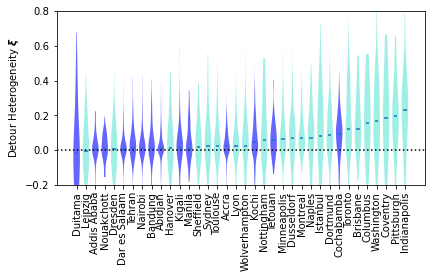

In [39]:
fig1,ax1=country_wise_Violin_plotter(dict_zig_zag,map_holder,Unorg_list,Org_dev,City_tag_list)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size"   : 12,
    "font.weight": "bold",
})

# plt.rcParams["font.weight"] = "bold"
# temp_label=['Cochabamba', 'Indianapolis', 'Montreal']
# i=5
plt.figure
# width, height = 90/25.4, 25/25.4
# plt.figure(figsize=(width, height))

plt.tight_layout()
plt.axhline(y = 0, color = 'black', linestyle = ':')
plt.ylim(-0.2,0.8)
plt.ylabel(r'Detour Heterogeneity $\xi$')
# plt.savefig('Route_Heterogeniety_Median_rerun.svg')
# plt.title('median')


## Population Weighted plots

In [ ]:
"""
Objective to make Violin plot with the population weightage to each route,
We weigh each route proportional to the population it intersects along it's path.
"""

"\nObjective to make Violin plot with the population weightage to each route,\nWe weigh each route proportional to the population it intersects along it's path.\n"

In [4]:
def pop_weighted_dict_generator_ratiod(dict_sample,pop_dist):
    dict_weightd={}
    pop_ratiod={}
    for i in np.arange(len(pop_dist)):
        pop_ratiod[i]=(pop_dist[i]/min(pop_dist[i])).astype(int)
    for i in np.arange(len(dict_sample)):
        print(i)
        temp=[]
        for j in np.arange(len(dict_sample[i])):
            for k in np.arange(int(pop_ratiod[i][j])):
                temp.append(dict_sample[i][j]) 

        dict_weightd[i]=temp
        
    return dict_weightd

In [ ]:
dict_cell_intersec_connected=dict(dict_cell_intersec)

for i in np.arange(len(dict_cell_intersec_connected)):
    if len(dict_no_connect_holder[i])>0:
        for j in dict_no_connect_holder[i][::-1]:
            print(j,i)
            dict_cell_intersec_connected[i].pop(j)
        

In [7]:
trial_1=pop_weighted_dict_generator_ratiod(dict_zig_zag,dict_cell_intersec)
trial2=pop_weighted_dict_generator_ratiod(dict_zig_zag,dict_cell_intersec)

fig1,ax1=country_wise_Violin_plotter(trial2,map_holder,Unorg_list,Org_dev,City_tag_list)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size"   : 12,
    "font.weight": "bold",
})


plt.figure
width, height = 90/25.4, 25/25.4
plt.figure(figsize=(width, height))

plt.tight_layout()
plt.axhline(y = 0, color = 'black', linestyle = ':')
# plt.ylim(-0,4)
plt.ylabel(r'Route Interconnectivity $I$')
# plt.ylabel(r'Total Detour $D$')
# plt.savefig('Route_Interconnectivity_Median_weighted_ratiod.svg')
# plt.title('median')
plt.show()


NameError: name 'dict_zig_zag' is not defined

## Calculating statistics on data

In [ ]:
"""
In the following we calculate rank statistics for different variables across cities,
The statistics imply wheter informal an formal transport are statistically different or are a mixed distribution
We calculate measure for detour heterogeniety, total detour, route interconnectivity and
the population weighted measures for these observables as well.
"""

In [ ]:
from scipy.stats import mannwhitneyu

def stat_mann_whit(Unorg_list,Devlpd_list,temp_avg_list):
    unorganised_zig=[]
    organised_zig=[]

    for i in np.arange(len(temp_avg_list)):
        if i in Unorg_list:
            unorganised_zig.append(temp_avg_list[i])
        elif i in Devlpd_list:
            organised_zig.append(temp_avg_list[i])
            
    U1, p = mannwhitneyu(unorganised_zig, organised_zig, method="auto",alternative='less')
    
    return U1,p,unorganised_zig,organised_zig

In [ ]:
unorganised_zig=[]
organised_zig=[]

for i in np.arange(len(unorg_org_list)):
    if unorg_org_list[i]==0:
        unorganised_zig.append(temp_avg_zig_zag[i])
    else:
        organised_zig.append(temp_avg_zig_zag[i])
        
print(np.mean(unorganised_zig),np.mean(organised_zig))

In [ ]:
U1,p,temp_1,temp_2= stat_mann_whit(Unorg_list,Devlpd_list,temp_median_diff_sum)
print(p,np.median(temp_1),np.median(temp_2))

In [ ]:
t1=pop_weighted_dict_generator(dict_zig_zag,dict_cell_intersec)
t2=pop_weighted_dict_generator(dict_diff_sum,dict_cell_intersec)
t3=pop_weighted_dict_generator(dict_all_route_changes_mean,dict_cell_intersec_connected)

temp_zig_whtd=[]
temp_deto_whtd=[]
temp_inter_whtd=[]
hline=[]

for i in np.arange(len(dict_zig_zag)):
    temp_zig_whtd.append(np.median(t1[i]))
    temp_deto_whtd.append(np.median(t2[i]))
    temp_inter_whtd.append(np.median(t3[i]))

## Correlation between Total Detour and Detour Heterogenity for cities

In [79]:
color_lister=[]
for i in np.arange(len(map_holder)):
    if i in Deving_list:
        color_lister.append('blue')
    elif i in Devlpd_list:
        color_lister.append('turquoise')

Org_dev.sort(reverse=True)

    

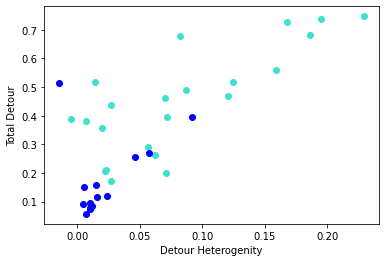

In [81]:
plt.figure()
for i in range(len(temp_avg_zig_zag)):
    plt.scatter(temp_median_zig_zag[i],temp_median_diff_sum[i],c=color_lister[i])
    # print(temp_avg_zig_zag[i],temp_avg_diff_sum[i],i,unorg_org_list[i])
# plt.plot(temp_avg_zig_zag,temp_avg_diff_sum,'.')
plt.xlabel('Detour Heterogenity')
plt.ylabel('Total Detour')
plt.savefig('detour_correlation_rerun.svg')
plt.show()



# Objective to plot Region wise plots

In [56]:
"""
Continent wise categarization and analysis for the observables.
"""

list_categories=[UK,USA,Canada,Europe,Australia,Africa,South_America,Asia,Global_North,Global_South]
unorg_region=[5,6,7,9]
org_region=[0,1,2,3,4,8]
label_x=['UK','USA','Canada','Europe','Australia','Africa','S America','Asia','Global North','Global South']

dict_regional_zig_zag={}
dict_regional_diff_sum={}
dict_regional_interconn={}

for i in np.arange(len(list_categories)):
    dict_regional_zig_zag[i]=[]
    dict_regional_diff_sum[i]=[]
    dict_regional_interconn[i]=[]
    for j in list_categories[i]:
        dict_regional_zig_zag[i].append(dict_zig_zag[j])
        dict_regional_diff_sum[i].append(dict_diff_sum[j])
        dict_regional_interconn[i].append(dict_all_route_changes_mean[j])
    
    dict_regional_zig_zag[i]=np.concatenate(dict_regional_zig_zag[i])
    dict_regional_diff_sum[i]=np.concatenate(dict_regional_diff_sum[i])
    dict_regional_interconn[i]=np.concatenate(dict_regional_interconn[i])


In [80]:
dict_zig_zag_wgtd=pop_weighted_dict_generator_ratiod(dict_zig_zag,dict_cell_intersec)
dict_diff_sum_wgtd=pop_weighted_dict_generator_ratiod(dict_diff_sum,dict_cell_intersec)
dict_all_route_changes_mean_wgtd=pop_weighted_dict_generator_ratiod(dict_all_route_changes_mean,dict_cell_intersec)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [101]:
"""
Continent wise categorization but with each rout weighted in proportion to the amount of population the route 
passes through
"""

list_categories=[UK,USA,Canada,Europe,Australia,Africa,South_America,Asia,Global_North,Global_South]
unorg_region=[5,6,7,9]
org_region=[0,1,2,3,4,8]
label_x=['UK','USA','Canada','Europe','Australia','Africa','S America','Asia','Global North','Global South']

dict_regional_zig_zag_wgtd={}
dict_regional_diff_sum_wgtd={}
dict_regional_interconn_wgtd={}

for i in np.arange(len(list_categories)):
    dict_regional_zig_zag_wgtd[i]=[]
    dict_regional_diff_sum_wgtd[i]=[]
    dict_regional_interconn_wgtd[i]=[]
    for j in list_categories[i]:
        dict_regional_zig_zag_wgtd[i].append(dict_zig_zag_wgtd[j])
        dict_regional_diff_sum_wgtd[i].append(dict_diff_sum_wgtd[j])
        dict_regional_interconn_wgtd[i].append(dict_all_route_changes_mean_wgtd[j])
    
    dict_regional_zig_zag_wgtd[i]=np.concatenate(dict_regional_zig_zag_wgtd[i])
    dict_regional_diff_sum_wgtd[i]=np.concatenate(dict_regional_diff_sum_wgtd[i])
    dict_regional_interconn_wgtd[i]=np.concatenate(dict_regional_interconn_wgtd[i])


921
[0.4712650296765785, 0.4190865537870688, 0.23376305827010488, 0.37593072649048787, 0.28407183035917305, 0.12067942196975191, 0.4151980391629465, 0.27232864235096066, 0.24502412163510745, 0.13043775125742715]


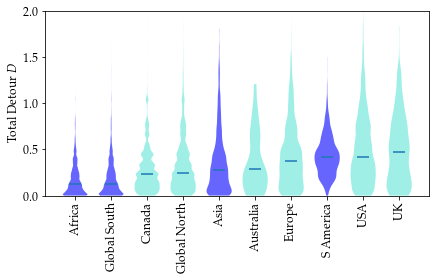

In [154]:
fig1,ax1=country_wise_Violin_plotter(dict_regional_diff_sum_wgtd,list_categories,unorg_region,[],label_x)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size"   : 12,
    "font.weight": "bold",
})

# plt.rcParams["font.weight"] = "bold"
# temp_label=['Cochabamba', 'Indianapolis', 'Montreal']
# i=5
plt.figure
# width, height = 90/25.4, 25/25.4
# plt.figure(figsize=(width, height))

plt.tight_layout()
# plt.axhline(y = 0, color = 'black', linestyle = ':')
plt.ylim(0,2)
plt.ylabel(r'Total Detour $D$')
plt.savefig('Total_Detour_region_wgtd.svg')
# plt.title('median')


921
[0.32432432432432434, 0.7662337662337663, 0.8055555555555556, 1.0657276995305165, 0.47761194029850745, 0.9365225390984361, 0.07906976744186046, 0.5851528384279476, 0.8194444444444444, 0.9135234590616376]


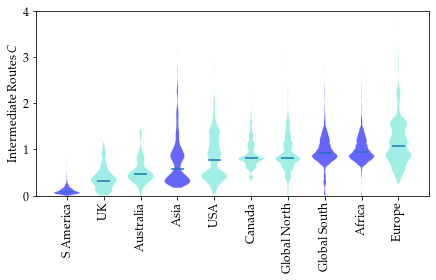

In [156]:
fig1,ax1=country_wise_Violin_plotter(dict_regional_interconn_wgtd,list_categories,unorg_region,[],label_x)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size"   : 12,
    "font.weight": "bold",
})

# plt.rcParams["font.weight"] = "bold"
# temp_label=['Cochabamba', 'Indianapolis', 'Montreal']
# i=5
plt.figure
# width, height = 90/25.4, 25/25.4
# plt.figure(figsize=(width, height))

plt.tight_layout()
# plt.axhline(y = 0, color = 'black', linestyle = ':')
plt.ylim(0,4)
plt.ylabel(r'Intermediate Routes $C$')
plt.savefig('Intermediate_routes_region_wgtd.svg')
# plt.title('median')


# Route Interconnectivity calculation for cities

In [ ]:
"""
The code calculates the interconnectivity of routes in a city.
Which is the number of changes required to go from one bus to another in a city.
"""

In [ ]:
changes_route_assemble=[]
frac_route_changes_exist=[]
dict_all_route_changes={}
dict_all_route_changes_mean={}
dict_no_connect_holder={}

for city in np.arange(len(map_holder)):
    path="/Users/kumi759c/Desktop/Paratransit_code/"+export_holder[city]
    print(path)
    gdf = geopandas.read_file(path)
    boroughs_4326 = gdf.to_crs("EPSG:4326")                                                                                  
    brs=boroughs_4326[boroughs_4326.id.str.contains('relation')].dropna(how='all', axis=1)              
    brs=brs[set(brs.columns)-{'.'}]
    dict_all_route_changes[city]=[]


    no_connect_holder=[]                
    temp_G = nx.Graph()
    for i in dict_arrray[city]:
        temp_G.add_node(i)

    for i in dict_arrray[city]:
        for j in dict_arrray[city]:
            if j>=i:
                temp_1=brs.iloc[i].geometry
                temp_2=brs.iloc[j].geometry

                if temp_1.intersects(temp_2)== True:
                    temp_G.add_edge(i,j)

    temp_len_accu=[]
    temp_frac_accu=[]
    for i in dict_arrray[city]:
        temp_len=[]
        temp_short_path=nx.shortest_path(temp_G, source=i)
        temp_frac_accu.append(len(temp_short_path)/len(dict_arrray[city]))
        if len(temp_short_path)==1:
            no_connect_holder.append(i)
        else:
            for j in temp_short_path:
                if len(temp_short_path[j])>1:
                       temp_len.append(len(temp_short_path[j])-2)

            dict_all_route_changes[city].append(temp_len)
            temp_len_accu.append(np.mean(temp_len))
        
    dict_no_connect_holder[city]=no_connect_holder
    dict_all_route_changes_mean[city]=temp_len_accu
    changes_route_assemble.append(np.mean(temp_len_accu))
    frac_route_changes_exist.append(np.mean(temp_frac_accu))

    
    

In [ ]:
np.save("dict_no_connect_holder_2.npy", dict_no_connect_holder)
np.save("dict_all_route_changes_mean_2.npy",dict_all_route_changes_mean)


In [ ]:
fig1,ax1=country_wise_Violin_plotter(dict_all_route_changes_mean,map_holder,Unorg_list,Org_dev,City_tag_list)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size"   : 12,
    "font.weight": "bold",
})

plt.figure
width, height = 90/25.4, 25/25.4
plt.figure(figsize=(width, height))

plt.tight_layout()
plt.ylim(-0,4)
plt.ylabel(r'Route Interconnectivity $I$')
# plt.savefig('Route_Inter.svg')
# plt.title('median')


# Population and route distribution plots for a general city

In [ ]:
"""
Code for ploting the population distribution according to Kontur population datset
Also the route density plots for routes passing throught the same hexagons.
"""

/Users/kumi759c/Desktop/Paratransit_code/map.geojson
/Users/kumi759c/Desktop/Paratransit_code/export.geojson


C:\Users\kumi759c\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\tools\Anaconda3\envs\ox\lib\site-packages\matplotlib\colors.py:1201: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
C:\tools\Anaconda3\envs\ox\lib\site-packages\matplotlib\colors.py:1202: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


<AxesSubplot:title={'center':'Ln Population Distribution'}>

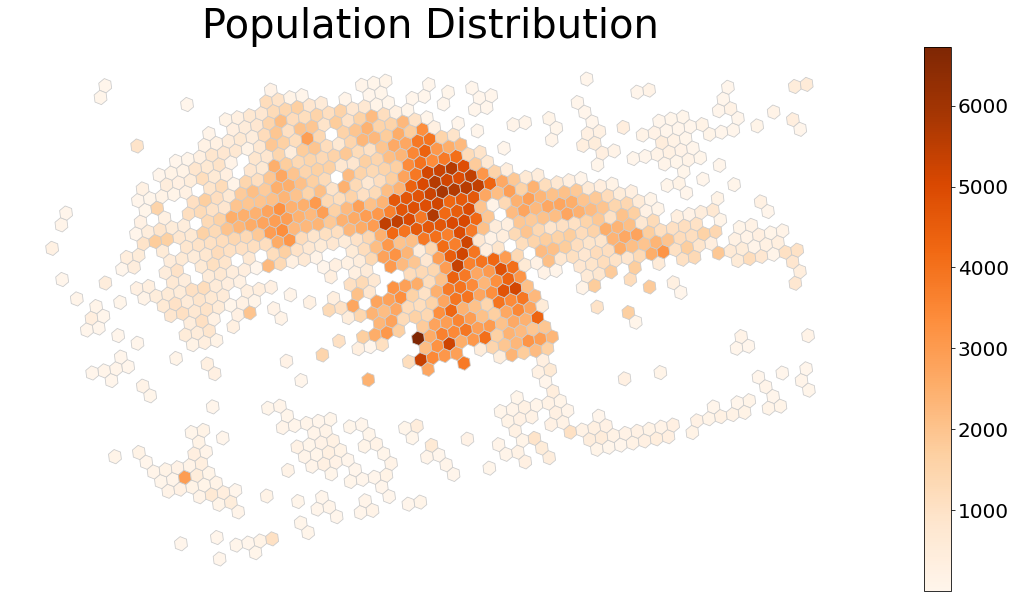

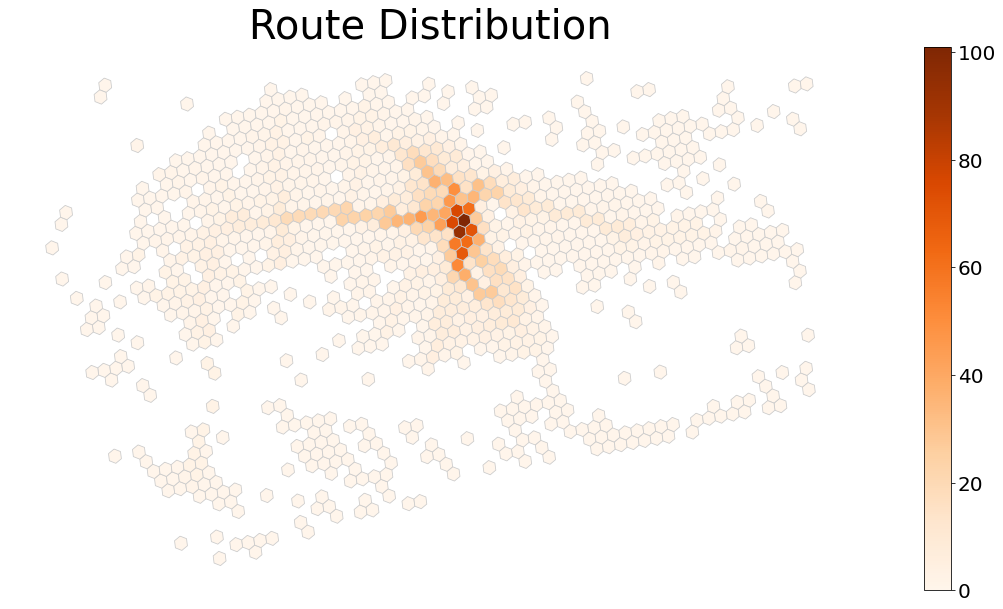

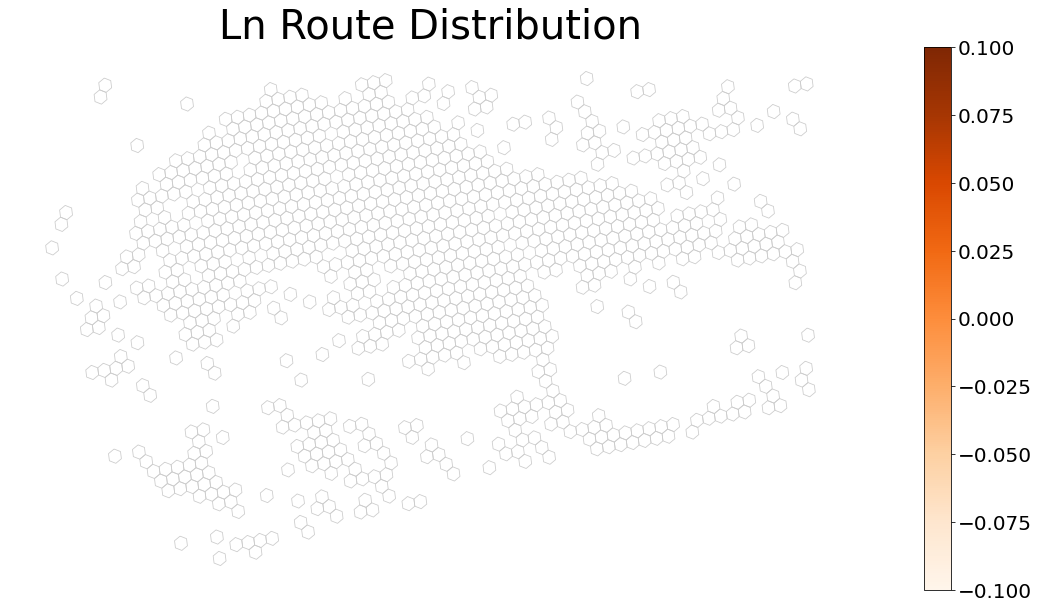

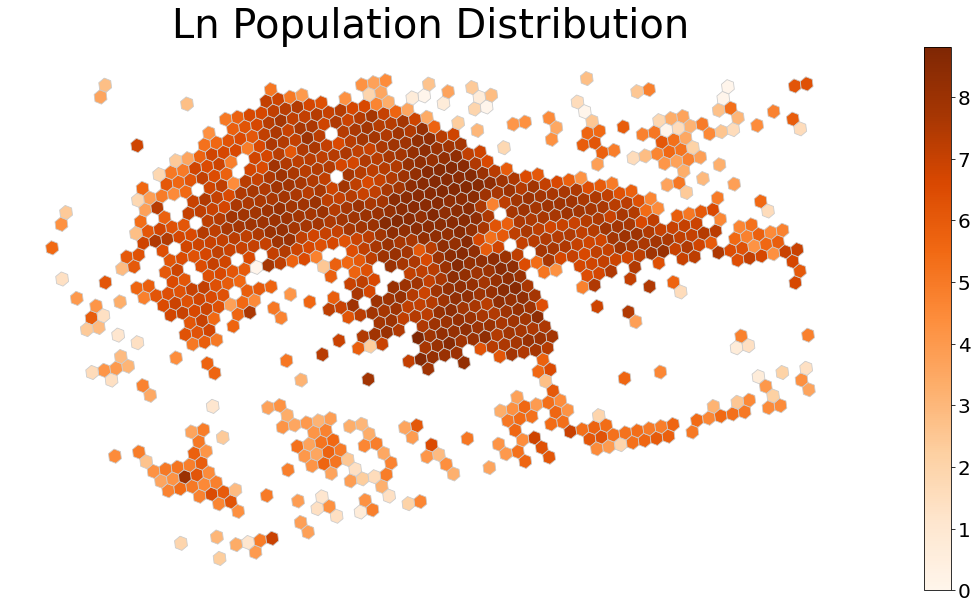

In [5]:
city=0

'initialising city data and boundary polygon'

path_to_json="/Users/kumi759c/Desktop/Paratransit_code/"+map_holder[city]
print(path_to_json)
polygon_city=get_polygon_from_json(path_to_json)

path="/Users/kumi759c/Desktop/Paratransit_code/"+export_holder[city]
print(path)
gdf = geopandas.read_file(path)
boroughs_4326 = gdf.to_crs("EPSG:4326")                                                                                  
brs=boroughs_4326[boroughs_4326.id.str.contains('relation')].dropna(how='all', axis=1)                       
brs=brs[set(brs.columns)-{'.'}]
brs=brs.dissolve(by='ref')
pop_dist_City=gpd.read_file("kontur_pop_EPSG.gpkg",mask=polygon_city)

'fig for population density'

fig, ax = plt.subplots(1, figsize=(25, 10))
ax.axis('off')
ax.set_title('Population Distribution', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = min(pop_dist_City['population']), max(pop_dist_City['population'])
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

pop_dist_City.plot('population', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
# fig.savefig('pop_dist.svg',format='svg')

' fig for route density, fist calculating number of routes per hexagon'

cell_intersec_holder=[]
dict_route_cell_num_holder={}

for i in np.arange(len(pop_dist_City)):
    dict_route_cell_num_holder[i]=[]
    temp_1=pop_dist_City.iloc[i].geometry
    temp_cell_counter=0
    for j in np.arange(len(brs)):
        temp_2=brs.iloc[j].geometry
        if temp_1.intersects(temp_2)== True:
            temp_cell_counter=temp_cell_counter+1
            dict_route_cell_num_holder[i].append(j)
            
    cell_intersec_holder.append(temp_cell_counter)                
                   
pop_dist_City['Routes']=cell_intersec_holder

fig, ax = plt.subplots(1, figsize=(25, 10))
ax.axis('off')
ax.set_title('Route Distribution', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = min(pop_dist_City['Routes']), max(pop_dist_City['Routes'])
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

pop_dist_City.plot('Routes', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
# fig.savefig('temp2.svg',format='svg')

pop_dist_City['log_pop']=np.log(pop_dist_City.population)
pop_dist_City['log_routes']=np.log(pop_dist_City.Routes)

fig, ax = plt.subplots(1, figsize=(25, 10))
ax.axis('off')
ax.set_title('Ln Route Distribution', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = min(pop_dist_City['log_routes']), max(pop_dist_City['log_routes'])
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

pop_dist_City.plot('log_routes', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))



fig, ax = plt.subplots(1, figsize=(25, 10))
ax.axis('off')
ax.set_title('Ln Population Distribution', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = min(pop_dist_City['log_pop']), max(pop_dist_City['log_pop'])
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

pop_dist_City.plot('log_pop', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))


# Calcultaing route, population densities and other relevant parameters. 

In [152]:
"""
    Extracting information of the number of routes in each city,
    Both the the distinct number of routes as well as the variations of a route in a city are noted
"""

num_route_all=[]
num_route_refd=[]
total_dist_refd=[]



for city in np.arange(len(map_holder)):
    
    path="/Users/kumi759c/Desktop/Paratransit_code/"+export_holder[city]
    print(path)
    gdf = geopandas.read_file(path)
    boroughs_4326 = gdf.to_crs("EPSG:4326")                                                                                  
    brs=boroughs_4326[boroughs_4326.id.str.contains('relation')].dropna(how='all', axis=1)                       
    brs=brs[set(brs.columns)-{'.'}]
    
    if city==35:
        num_route_all.append(len(brs))
        num_route_refd.append(len(brs))
    
    else:
        gb = brs.groupby('ref') 
        num_route_all.append(len(brs))
        num_route_refd.append(len(gb))
        temp_len_sum=0
        for i in (dict(gb.groups)).keys():

            temp_route=brs.iloc[(dict(gb.groups)[i][0])].geometry 
            if str(type(brs.iloc[(dict(gb.groups)[i][0])].geometry))=="<class 'shapely.geometry.multilinestring.MultiLineString'>":
                temp_coords=list(temp_route[0].coords)
                temp_len_sum=temp_len_sum+list_dist_meter(temp_coords)


            elif str(type(brs.iloc[(dict(gb.groups)[i][0])].geometry))=="<class 'shapely.geometry.polygon.Polygon'>":
                continue

            else: 
                temp_coords=list(temp_route.coords)
                temp_len_sum=temp_len_sum+list_dist_meter(temp_coords)


        total_dist_refd.append(temp_len_sum)

        
        

/Users/kumi759c/Desktop/Paratransit_code/export.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Accra.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Addis_Ababa.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Bangalore.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Brisbane.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Buenos_Aires.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Cape_Town.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Columbus.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Coventry.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Dortmund.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Dresden.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Duitama.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Dusseldorf.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Hannover.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Indianapolis.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Istanbul.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Leipzig.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Lyon.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Minneapolis.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Montreal.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Napoli.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Nottingham.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Nouakchott.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Pittsburg.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Sheffield.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Sydney.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Tetouan.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Toronto.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Toulose.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Washigton.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_Wolverampthon.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_z_Abidjan.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_z_Bandung.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_z_Dar_es_Salaam.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_z_Kigali.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_z_Kochi.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_z_Manila_PUJ_only.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_z_Nairobi.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


/Users/kumi759c/Desktop/Paratransit_code/export_z_Tehran.geojson


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_17184/1536302105.py:34: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  temp_coords=list(temp_route[0].coords)


## Calculating area density and other metric using kontour population data


In [ ]:
"""
We calculate here the are and population density of routes.
Area and population are measured as the sum of the area and populations of all the routes in a city with
atleast one route passing through them.
"""

hexa_rout_pop=[]
hexa_rout_area=[]
hexa_rout_pop_den=[]

city_rout_pop=[]
city_rout_area=[]
city_rout_pop_den=[]

hexa_rout_pop_grpd=[]
hexa_rout_area_grpd=[]
hexa_rout_pop_den_grpd=[]

city_rout_pop_grpd=[]
city_rout_area_grpd=[]
city_rout_pop_den_grpd=[]

city_area=[]
city_pop=[]

num_hexagon=[]
num_line_hexa=[]

for city in np.arange(len(map_holder)):

    'initialising city data and boundary polygon'

    path_to_json="/Users/kumi759c/Desktop/Paratransit_code/"+map_holder[city]
    print(path_to_json)
    polygon_city=get_polygon_from_json(path_to_json)

    path="/Users/kumi759c/Desktop/Paratransit_code/"+export_holder[city]
    print(path)
    gdf = geopandas.read_file(path)
    boroughs_4326 = gdf.to_crs("EPSG:4326")                                                                                  
    brs=boroughs_4326[boroughs_4326.id.str.contains('relation')].dropna(how='all', axis=1)                       
    brs=brs[set(brs.columns)-{'.'}]

   

    if city==35:
        tot_route=len(brs)
        tot_route_grpd=len(brs)
    
    else:
        
        gb = brs.groupby('ref') 
 
        tot_route=len(brs)
        tot_route_grpd=len(gb)
    
    
    pop_dist_City=gpd.read_file("kontur_pop_EPSG.gpkg",mask=polygon_city)


    temp_cell_intersec_holder=[]

    for i in np.arange(len(pop_dist_City)):

        temp_1=pop_dist_City.iloc[i].geometry
        temp_cell_counter=0
        for j in np.arange(len(brs)):
            temp_2=brs.iloc[j].geometry
            if temp_1.intersects(temp_2)== True:
                temp_cell_counter=temp_cell_counter+1

        temp_cell_intersec_holder.append(temp_cell_counter)                

    pop_dist_City['Routes']=temp_cell_intersec_holder
    
    pop_dist_city_area=pop_dist_City.to_crs({'init': 'epsg:6933'})
    pop_dist_City['area_km2']=pop_dist_city_area.area/ 10**6
    pop_dist_City['pop_area_km2']=pop_dist_City['population']/pop_dist_City['area_km2']
    
    pop_dist_City['route_pop_den']=pop_dist_City['Routes']/pop_dist_City['pop_area_km2']
    pop_dist_City['route_area']=pop_dist_City['Routes']/pop_dist_City['area_km2']
    pop_dist_City['route_pop']=pop_dist_City['Routes']/pop_dist_City['population']
    
    pop_dist_City.drop(pop_dist_City.index[(pop_dist_City["Routes"] == 0)],axis=0,inplace=True)
    
    tot_area=np.sum(pop_dist_City['area_km2'])
    tot_pop=np.sum(pop_dist_City['population'])
    tot_pop_area=tot_pop/tot_area
    
    num_hexagon.append(len(pop_dist_City))
    
    city_area.append(tot_area)
    city_pop.append(tot_pop)
    
    hexa_rout_pop.append(np.mean(pop_dist_City['route_pop']))
    hexa_rout_area.append(np.mean(pop_dist_City['route_area']))
    hexa_rout_pop_den.append(np.mean(pop_dist_City['route_pop_den']))
    
    city_rout_pop.append(tot_route/tot_pop)
    city_rout_area.append(tot_route/tot_area)
    city_rout_pop_den.append(tot_route/tot_pop_area)
    
    city_rout_pop_grpd.append(tot_route_grpd/tot_pop)
    city_rout_area_grpd.append(tot_route_grpd/tot_area)
    city_rout_pop_den_grpd.append(tot_route_grpd/tot_pop_area)
    num_line_hexa.append(tot_route_grpd/len(pop_dist_City))
    
    print(pop_dist_City['area_km2'])
    


In [ ]:
hex_pop_den=np.array(city_pop)/np.array(num_hexagon)

In [ ]:
hex_route_den=np.array(num_route_refd)/hex_pop_den
a,b=dev_devlpni_seprator(Deving_list,hex_route_den,map_holder)
print(np.mean(a),np.std(a),np.mean(b),np.std(b))

In [ ]:
num_route_line=np.array(num_route_all)/np.array(num_route_refd)
a,b=dev_devlpni_seprator(Deving_list,num_route_line,map_holder)
print(np.mean(a),np.std(a),np.mean(b),np.std(b))
print(np.percentile(a,10), np.percentile(a,90), np.percentile(b,10), np.percentile(b,90))
print(np.percentile(a,5), np.percentile(a,95), np.percentile(b,5), np.percentile(b,95))
print(np.percentile(a,25), np.percentile(a,75), np.percentile(b,25), np.percentile(b,75))

# Model 

In [6]:
"""
We create model routes in a city with a city centre,
Here the routes start and end in the outskirts and pass through city centre in the middle
"""

r_area_srvd_bus=20
theta_angle_srvd=np.radians(0.25)
total_bus_len=1000
gap_btwn=0.5

tab_seg=1
tab_altr=1

num_point_base=50

r_array_line=[]
theta_array_line=[]

current_len=0

while current_len+r_area_srvd_bus<total_bus_len:
        r_array_line += list(np.linspace((tab_seg-1)*r_area_srvd_bus,(tab_seg)*r_area_srvd_bus,int(r_area_srvd_bus/gap_btwn)))
        
        for j in np.arange(int(r_area_srvd_bus/gap_btwn)):
            theta_array_line.append(tab_altr*theta_angle_srvd)
        
        current_len=current_len+r_area_srvd_bus

        # adding arc now
        for i in np.arange(int(2*r_area_srvd_bus*tab_seg*theta_angle_srvd/gap_btwn)):
            r_array_line.append(r_area_srvd_bus*tab_seg)
        
        theta_array_line+=list(np.linspace(tab_altr*theta_angle_srvd,(-tab_altr)*theta_angle_srvd,int(2*r_area_srvd_bus*tab_seg*theta_angle_srvd/gap_btwn)))
        
        current_len=current_len+(2*r_area_srvd_bus*tab_seg*theta_angle_srvd)
        
        tab_altr=-tab_altr
        tab_seg=tab_seg+1
    
        
    

x_bus = r_array_line * np.cos(theta_array_line)
x_bus_neg=-x_bus
y_bus = r_array_line * np.sin(theta_array_line)
y_bus_neg=-y_bus

x_cord_bus=np.concatenate((x_bus_neg[::-1],x_bus))
y_cord_bus=np.concatenate((y_bus_neg[::-1],y_bus))

geo_line = LineString(zip(x_cord_bus, y_cord_bus))

# Convert LineString to GeoSeries
line_gdf = gpd.GeoSeries(geo_line)

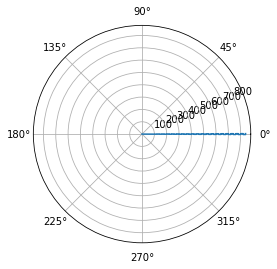

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_array_line, r_array_line)

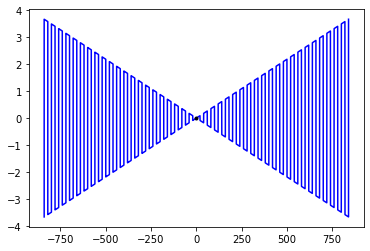

In [9]:
plt.plot(x_cord_bus,y_cord_bus,'b')
plt.plot([0],[0],'k.')
# plt.xlim(-300,300)
# plt.savefig('model_route.svg')

In [ ]:
parts_route=3
total_scan_points=50

split_route_assemble =split_route_distance_scan(list(geo_line.coords),parts_route,total_scan_points)

In [ ]:
direct_eucl_dist_seg=[]
path_dist_seg=[]

for i in np.arange(len(split_route_assemble)):
    path_dist_seg.append(list_dist(split_route_assemble[i]))
    direct_eucl_dist_seg.append(np.sqrt((split_route_assemble[i][0][0]-split_route_assemble[i][-1][0])**2+(split_route_assemble[i][0][1]-split_route_assemble[i][-1][1])**2))
    
detor_seg=(np.array(path_dist_seg)-np.array(direct_eucl_dist_seg))/np.array(path_dist_seg)    

In [ ]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size"   : 12,
    "font.weight": "bold",
})

# plt.rcParams["font.weight"] = "bold"
# temp_label=['Cochabamba', 'Indianapolis', 'Montreal']
# i=5
plt.figure
width, height = 90/25.4, 60/25.4
plt.figure(figsize=(width, height))
# temp=0
# for i in [i]:
        # plt.plot([0,1,2],[1/(sum(dict_actual_dist[i][0])/sum(dict_actual_dist[i][0])),1/(sum(dict_actual_dist[i][1])/sum(dict_actual_dist[i][1])),1/(sum(dict_actual_dist[i][2])/sum(dict_actual_dist[i][2]))])
plt.plot(np.arange(len(detor_seg)),detor_seg,'.-',c='blueviolet')
    # plt.plot(np.arange(len(dict_actual_dist[key])),(sum_act_dist-sum_shortest_dist)/sum_act_dist)
# temp=temp+1
# plt.xticks([0,1,2],[1,2,3])
plt.ylabel("Detour Fraction $d$")
plt.xlabel("Segment position $x$ ")
# plt.ylim(0,0.36)
plt.ylim(0,0.4)
# plt.yticks((0,0.1,0.2,0.3,0.4,0.5),(0,0.1,0.2,0.3,0.4,0.5))
# plt.yticks((0,0.2,0.4,0.6),(0,0.2,0.4,0.6))
# plt.xticks(np.append(np.arange(len(temp_route_actual))[::5],50),np.append((np.arange(len(temp_route_actual))/len(temp_route_actual))[::5],1))
plt.xticks([0,12.5,25,37.5,50],[0,12.5/50,25/50,37.5/50,50/50])
# plt.xticks(np.arange(len(dict_actual_dist[0])),np.arange(len(dict_actual_dist[0]))/(len(dict_actual_dist[0])))
# plt.legend(['Detour Fraction'])
plt.tick_params(axis='both', direction='in', length=4)
plt.savefig('model_r_20_theta_0_25_l_20_alt.svg')
plt.show()

# Overlap between routes belonging to same bus number

In [ ]:
"""
Here we find the overlap between different routes belonging to the same bus number
Objective is to see variations in the routes a bus might possibly opt for.
"""

In [304]:
from itertools import combinations

all_city_overlap={}
all_city_one_route={}


for city in np.arange(len(map_holder)):
    if city==35:
        all_city_overlap[city]=[1]
        all_city_one_route[city]=[1]
    
    else:
        path="/Users/kumi759c/Desktop/Paratransit_code/"+export_holder[city]
        print(path)
        gdf = geopandas.read_file(path)
        boroughs_4326 = gdf.to_crs(3043)                                                                                
        brs=boroughs_4326[boroughs_4326.id.str.contains('relation')].dropna(how='all', axis=1)                       
        brs=brs[set(brs.columns)-{'.'}]

        grouper=brs.groupby('ref')
        list_group_tag=[]

        for i_1,j_1 in grouper:
            list_group_tag.append(j_1)


        buffer=30
        overlap_city=[]
        route_length_average=[]
        fraction_overlap=[]

        list_group_tag[0]
        only_one_route=0
        for num_grp in np.arange(len(list_group_tag)):

                if len(list_group_tag[num_grp])==1:
                    only_one_route=only_one_route+1

                elif len(list_group_tag[num_grp])==2:
                    line=list_group_tag[num_grp].iloc[0].geometry.buffer(buffer)
                    line1=list_group_tag[num_grp].iloc[1].geometry.buffer(buffer)
                    # print(line.length,line1.length)
                    avg_len=((line.length+line1.length)/2)

                    intersection = line.intersection(line1)
                    if intersection.is_empty:
                        overlap_length = 0
                    else:
                        overlap_length = intersection.length

                    overlap_city.append(overlap_length)
                    route_length_average.append(avg_len)
                    fraction_overlap.append((overlap_length/avg_len)*100)

                else:
                    pair_wise_list=list(combinations(np.arange(len(list_group_tag[num_grp])), 2))

                    pair_fraction=[]

                    for pair in pair_wise_list:
                            line=list_group_tag[num_grp].iloc[pair[0]].geometry.buffer(buffer)
                            line1=list_group_tag[num_grp].iloc[pair[1]].geometry.buffer(buffer)
                            avg_len=((line.length+line1.length)/2)

                            intersection = line.intersection(line1)
                            if intersection.is_empty:
                                overlap_length = 0
                            else:
                                overlap_length = intersection.length

                            overlap_city.append(overlap_length)
                            route_length_average.append(avg_len)
                            pair_fraction.append((overlap_length/avg_len)*100)

                    fraction_overlap.append(np.mean(pair_fraction))



        all_city_overlap[city]=fraction_overlap
        all_city_one_route[city]=only_one_route

/Users/kumi759c/Desktop/Paratransit_code/export.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Accra.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Addis_Ababa.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Bangalore.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Brisbane.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Buenos_Aires.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Cape_Town.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Columbus.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Coventry.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Dortmund.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Dresden.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Duitama.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Dusseldorf.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Hannover.geojson
/Users/kumi759c/Desktop/Paratransit_code/export_Indianapolis.geojson
/Users/kumi759c/Desktop/

In [335]:
def country_wise_Violin_plotter(dict_zig_zag,map_holder,Deving_list,popper,City_tag_list):
    temp=[]
    temp_mean=[]
    order_tracker=np.arange(len(map_holder))
    median_devlp=[]
    median_devpin=[]
    
    for i in np.arange(len(dict_zig_zag)):
        temp.append(dict_zig_zag[i])
        temp_mean.append(np.median(dict_zig_zag[i]))

    sorted_temp=[x for _,x in sorted(zip(temp_mean,temp))]
    sorted_order=[x for _,x in sorted(zip(temp_mean,order_tracker))]
    sorted_city_tag=[x for _,x in sorted(zip(temp_mean,City_tag_list))]
    
    if len(popper)>0:
        for i in popper:
            print(i)
            sorted_temp.pop(sorted_order.index(i))
            sorted_city_tag.pop(sorted_order.index(i))
            sorted_order.pop(sorted_order.index(i))

    
    
    fig, ax = plt.subplots()

    vp = ax.violinplot(sorted_temp,np.arange(len(sorted_temp)), widths=0.7,
                       showmeans=False, showmedians=True, showextrema=False,vert=True)

    for i in np.arange(len(sorted_order)):
        if sorted_order[i] in Deving_list:
            vp['bodies'][i].set_facecolor('blue')
            vp['bodies'][i].set_alpha(0.6)
            median_devpin.append(np.median(sorted_temp[i]))
            # vp['bodies'][i].set_edgecolor('black')
        else:
            vp['bodies'][i].set_facecolor('turquoise')
            vp['bodies'][i].set_alpha(0.5)
            # vp['bodies'][i].set_edgecolor('black')
            median_devlp.append(np.median(sorted_temp[i]))
    
    plt.xticks(np.arange(len(sorted_city_tag)),sorted_city_tag)
    plt.xticks(rotation=90)
    
    print(median_devlp)
    print(median_devpin)
    print(np.median(median_devlp),np.median(median_devpin))

    return fig,ax
        


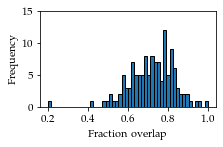

In [585]:
width, height = 80/25.4, 45/25.4
plt.figure(figsize=(width, height))

plt.hist(np.array(all_city_overlap[0])/100, bins=50, edgecolor='black')
# plt.title('Average overlap')
plt.xlabel(r'Fraction overlap')
plt.ylabel(r'Frequency')
plt.ylim(0,15)
plt.savefig('route_overlap.svg')

In [520]:
gb = brs.groupby('ref')
list(gb['ref'].count())

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 8,
 2,
 4,
 4,
 5,
 4,
 2,
 6,
 8,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 6,
 4,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 2,
 6,
 8,
 8,
 10,
 8,
 14,
 2,
 4,
 12,
 6,
 2,
 2,
 2,
 2,
 11,
 2,
 8,
 2,
 8,
 14,
 5,
 2,
 14,
 2,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 4,
 2,
 2,
 6,
 1,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 6,
 4,
 2,
 2]

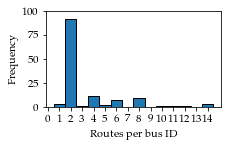

In [586]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size"   : 11,
    "font.weight": "bold",
})

width, height = 80/25.4, 45/25.4
plt.figure(figsize=(width, height))

len(all_city_overlap[0])
bin_edges=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5]
plt.hist(list(gb['ref'].count()), bins=bin_edges, edgecolor='black')
# plt.title('Average overlap')
plt.xlabel(r'Routes per bus ID')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
plt.ylim(0,100)
plt.ylabel(r'Frequency')
plt.savefig('routes_per_ID.svg')

In [ ]:


# plt.rcParams["font.weight"] = "bold"
# temp_label=['Cochabamba', 'Indianapolis', 'Montreal']
# i=5
plt.figure
width, height = 90/25.4, 60/25.4
plt.figure(figsize=(width, height))
# temp=0
# for i in [i]:
        # plt.plot([0,1,2],[1/(sum(dict_actual_dist[i][0])/sum(dict_actual_dist[i][0])),1/(sum(dict_actual_dist[i][1])/sum(dict_actual_dist[i][1])),1/(sum(dict_actual_dist[i][2])/sum(dict_actual_dist[i][2]))])
plt.plot(np.arange(len(detor_seg)),detor_seg,'.-',c='blueviolet')
    # plt.plot(np.arange(len(dict_actual_dist[key])),(sum_act_dist-sum_shortest_dist)/sum_act_dist)
# temp=temp+1
# plt.xticks([0,1,2],[1,2,3])
plt.ylabel("Detour Fraction $d$")
plt.xlabel("Segment position $x$ ")
# plt.ylim(0,0.36)
plt.ylim(0,0.4)
# plt.yticks((0,0.1,0.2,0.3,0.4,0.5),(0,0.1,0.2,0.3,0.4,0.5))
# plt.yticks((0,0.2,0.4,0.6),(0,0.2,0.4,0.6))
# plt.xticks(np.append(np.arange(len(temp_route_actual))[::5],50),np.append((np.arange(len(temp_route_actual))/len(temp_route_actual))[::5],1))
plt.xticks([0,12.5,25,37.5,50],[0,12.5/50,25/50,37.5/50,50/50])
# plt.xticks(np.arange(len(dict_actual_dist[0])),np.arange(len(dict_actual_dist[0]))/(len(dict_actual_dist[0])))
# plt.legend(['Detour Fraction'])
plt.tick_params(axis='both', direction='in', length=4)
plt.savefig('model_r_20_theta_0_25_l_20_alt.svg')
plt.show()x

# Entropy of routes

In [ ]:
"""
Here we define the entropy of routes as an alternate measure for detour heterogeniety.
We restrict from using this as our observable in the main manuscript 
becasuse of it's limitations in terms of geometric interpretation.
"""

In [ ]:
key=0

detour_collector=(np.array(dict_actual_dist[key])-np.array(dict_shortest_dist[key]))/np.array(dict_actual_dist[key])

s_min=-np.log(50)
s_max=0

entropy_collector=[]

for i in np.arange(len(detour_collector[0])):
    temp=detour_collector[:,i]/np.sum(detour_collector[:,i])
    temp=temp*np.log(temp)
    entropy_collector.append(np.nansum(temp))

print(np.sum(entropy_collector/np.sum(entropy_collector)))
print(np.max(entropy_collector))
print(np.min(entropy_collector))
print(s_min)
entropy_collector=1-entropy_collector/s_min

1.0
-1.41549558617592
-3.899196920706432
-3.912023005428146


C:\Users\kumi759c\AppData\Local\Temp/ipykernel_7016/1826021237.py:10: RuntimeWarning: divide by zero encountered in log
  temp=temp*np.log(temp)
C:\Users\kumi759c\AppData\Local\Temp/ipykernel_7016/1826021237.py:10: RuntimeWarning: invalid value encountered in multiply
  temp=temp*np.log(temp)


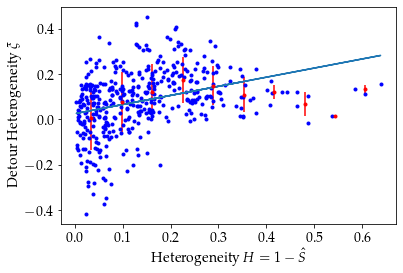

In [ ]:
binned_hist_error(entropy_collector,dict_zig_zag[0],10,r'Heterogeneity $H=1-\hat{S}$',r'Detour Heterogeneity $\xi$','')
plt.savefig("/Users/kumi759c/Desktop/Paratransit_code/hetro_entropy.svg")

# Street network analysis to check street type

In [2]:
""" Calculating the different street type a route segment operates on,
We then see the detour of the route segment and the fraction of different types of street to understand
influence of street type on route detours"""

' \nCalculating the different street type a route segment operates on,\nWe then see the detour of the route segment and the fraction of different types of street to understand\ninfluence of street type on route detours.\n'

In [41]:
list_category_street=['secondary_link',
 'footway',
 'service',
 'primary',
 'cycleway',
 'unclassified',
 'trunk',
 'rest_area',
 'tertiary',
 'corridor',
 'path',
 'tertiary_link',
 'primary_link',
 'track',
 'secondary',
 'trunk_link',
 'living_street',
 'steps',
 'residential',
 'pedestrian'
 ]

In [ ]:
list_category_street_grouped=['Trunk','Primary','Secondary','Tertiary','Residential','Others']

In [104]:
dict_shortest_route=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_short_full_run_2.npy", allow_pickle=True).item()
dict_actual_dist=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_act_dist_full_run_2.npy", allow_pickle=True).item()
dict_shortest_dist=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_short_dist_full_run_2.npy", allow_pickle=True).item()
dict_total_dist=np.load("/Users/kumi759c/Desktop/Paratransit_code/Saved_full_run_2/dict_total_dist_full_run_2.npy", allow_pickle=True).item()

for i in np.arange(len(dict_actual_route)):
    for j in np.arange(len(dict_actual_dist[i])):
        for k in np.arange(len(dict_actual_dist[i][j])):
            if dict_actual_dist[i][j][k]<dict_shortest_dist[i][j][k]:
                dict_shortest_dist[i][j][k]=dict_actual_dist[i][j][k]


In [106]:
dict_sum_holder={}
dict_sum_holder[city]=[]
dict_deto_holder={}
dict_deto_holder[city]=[]
for route in np.arange(len(brs)):
    for segno in [0,1,2]:
        temp_deto=(dict_actual_dist[city][segno][route]-dict_shortest_dist[city][segno][route])/(np.array(dict_total_dist[city][route])/3)
        temp_int=edges.intersection(dict_shortest_route[city][segno][route])
        empty_mask=temp_int.geometry.is_empty
        gdf_non_empty = temp_int[~empty_mask]

        list_street_holder=[]
        for i in np.arange(len(list_category_street)):
            list_street_holder.append([])

        for segn in np.arange(len(gdf_non_empty)):
            if edges.loc[gdf_non_empty.index[segn],'highway'] in list_category_street:
                list_street_holder[list_category_street.index(edges.loc[gdf_non_empty.index[segn],'highway'])].append(edges.loc[gdf_non_empty.index[segn],'length'])
            else:
                continue

        list_street_holder_sum=[]
        for summer in list_street_holder:
            list_street_holder_sum.append(sum(summer))

        dict_sum_holder[city].append(list_street_holder_sum)
        dict_deto_holder[city].append(temp_deto)

In [114]:
dict_frac_holder={}
for i in dict_sum_holder:
    dict_frac_holder[i]=[]
    for j in dict_sum_holder[i]:
        dict_frac_holder[i].append(j/sum(j))

In [121]:
dict_frac_holder_grp={}
dict_frac_holder_grp[0]=[]
for i in np.arange(len(dict_frac_holder[0])):
    temp_trunk=dict_frac_holder[0][i][6]+dict_frac_holder[0][i][15]
    temp_primary=dict_frac_holder[0][i][3]+dict_frac_holder[0][i][12]
    temp_secondary=dict_frac_holder[0][i][0]+dict_frac_holder[0][i][14]
    temp_tertiary=dict_frac_holder[0][i][8]+dict_frac_holder[0][i][11]
    temp_residential=dict_frac_holder[0][i][18]+dict_frac_holder[0][i][16]
    temp_others=sum(dict_frac_holder[0][i])-temp_trunk-temp_primary-temp_secondary-temp_tertiary-temp_residential
    
    dict_frac_holder_grp[0].append([temp_trunk,temp_primary,temp_secondary,temp_tertiary,temp_residential,temp_others])

In [146]:
city=0
dict_deto_frac={}
dict_deto_frac[city]=[]
for i in np.arange(len(dict_frac_holder_grp[city])):
    dict_deto_frac[city].append((np.array(dict_frac_holder_grp[city][i])*np.array(dict_deto_holder[city][i]))/sum(dict_deto_holder[0]))

In [173]:
deto_fra=np.round(np.sum((np.array(dict_deto_frac[0])),axis=0),3)

In [172]:
segm_fra=np.round(np.sum((np.array(dict_frac_holder_grp[0])),axis=0)/sum(np.sum((np.array(dict_frac_holder_grp[0])),axis=0)),3)

In [247]:
temp_string='/Users/kumi759c/Desktop/Paratransit_code/Street_type_seg'

os.mkdir(temp_string)

np.save(temp_string+"/dict_sum_holder.npy",dict_sum_holder)
np.save(temp_string+"/dict_frac_holder.npy",dict_frac_holder)